### Import libraries and datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.outliers_influence as out_infl
import warnings
warnings.filterwarnings("ignore")

theft_log_df = pd.read_csv('theft_log.csv',header=None)
visitor_log_df = pd.read_csv('visitor_log.csv')

### Data Cleaning

In [2]:
# Check missing values
print('Visitor Log:')
print(visitor_log_df.isnull().any())
print('\nTheft Log:')
print(theft_log_df.isnull().any())

# Count unique dates, names, dob
print('\nNumber of unique days:', len(visitor_log_df['visit_date'].unique()))
print('Number of unique names:', len(visitor_log_df['name'].unique()))
print('Number of unique DOB:', len(visitor_log_df['dob'].unique()))

# Create user id, combine name with DOB as primary key
visitor_log_df['visitor_id'] = visitor_log_df.groupby(['name','dob']).grouper.group_info[0]
print('Number of unique visitors:', len(visitor_log_df['visitor_id'].unique()))
visitor_log_df.head()

Visitor Log:
visit_date    False
name          False
dob           False
dtype: bool

Theft Log:
0    False
dtype: bool

Number of unique days: 200
Number of unique names: 985
Number of unique DOB: 729
Number of unique visitors: 992


,visit_date,name,dob,visitor_id
0,2016-06-16,Samuel Casanova,1990-03-12,834
1,2016-06-16,Gerald Orozco,1990-10-05,299
2,2016-06-16,Sharon Davis,1990-10-18,853
3,2016-06-16,Spencer Spencer,1991-10-13,875
4,2016-06-16,Steven Estevez,1992-01-13,883


### Create visitor dataframe 

In [3]:
visitor_df = visitor_log_df[['name', 'dob', 'visitor_id']]
visitor_df = visitor_df.drop_duplicates() # remove duplicate visitor entries 
visitor_df = visitor_df.sort_values(by=['visitor_id']) # Sort data by visitor id
visitor_df = visitor_df.reset_index(drop=True)
visitor_df.head()

,name,dob,visitor_id
0,Aaron Nelson,1994-12-12,0
1,Ada Tejeda,1997-05-24,1
2,Adam Berry,1995-11-02,2
3,Adam Dorsette,1996-12-07,3
4,Adam Johnson,1996-04-11,4


In [4]:
# Count total visit for each visitor
visitor_df['total_visit_count'] = visitor_log_df['visitor_id'].value_counts().sort_index()

# Count visit on dates with theft report for each visitor
visitor_log_df = visitor_log_df[visitor_log_df.visit_date.isin(list(theft_log_df[0]))]
visitor_df['theft_visit_count'] = visitor_log_df['visitor_id'].value_counts().sort_index()

# Remove visitor with no visit on theft reported dates
visitor_df = visitor_df.dropna()
visitor_df['theft_visit_count'] = visitor_df['theft_visit_count'].astype(int)

# Calculate theft visit over total visit ratio 
visitor_df['theft_visit_ratio'] = visitor_df['theft_visit_count'] / visitor_df['total_visit_count']
visitor_df = visitor_df.reset_index(drop=True)
visitor_df.head()

,name,dob,visitor_id,total_visit_count,theft_visit_count,theft_visit_ratio
0,Aaron Nelson,1994-12-12,0,67,11,0.164179
1,Ada Tejeda,1997-05-24,1,145,22,0.151724
2,Adam Berry,1995-11-02,2,26,5,0.192308
3,Adam Dorsette,1996-12-07,3,13,4,0.307692
4,Adam Johnson,1996-04-11,4,73,13,0.178082


### Statistical analysis of numerical variables of visitor data

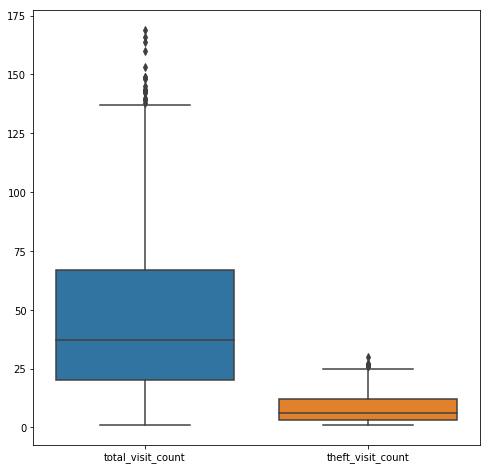

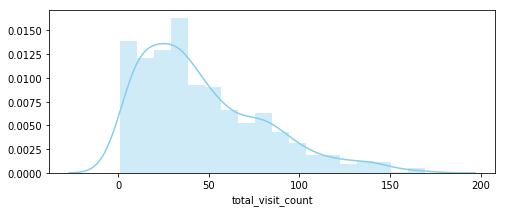

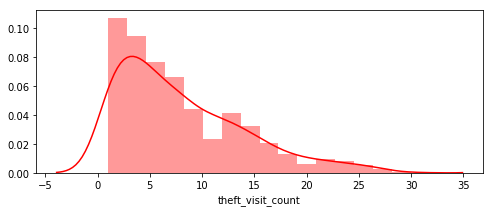

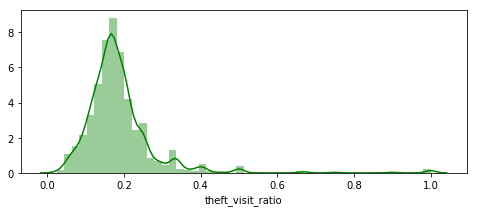

,total_visit_count,theft_visit_count,theft_visit_ratio
count,911.00,911.00,911.00
mean,46.44,8.00,0.19
std,34.24,6.05,0.10
min,1.00,1.00,0.02
25%,20.00,3.00,0.14
50%,37.00,6.00,0.17
75%,67.00,12.00,0.21
max,169.00,30.00,1.00


In [5]:
# Boxplot
plt.rcParams['figure.figsize'] = (8, 8)
sns.boxplot(data=visitor_df.iloc[:,3:5])
plt.show()

# Histogram
plt.rcParams['figure.figsize'] = (8, 3)
sns.distplot( visitor_df["total_visit_count"] , color="skyblue", label="Sepal Length")
plt.show()
sns.distplot( visitor_df["theft_visit_count"] , color="red", label="Sepal Width")
plt.show()
sns.distplot( visitor_df["theft_visit_ratio"] , color="green", label="Sepal Width")
plt.show()

# Statistical summary
visitor_df[['total_visit_count','theft_visit_count','theft_visit_ratio']].describe().round(2)

Several outliers of total_visit_count and theft_visit_count can be observed from the boxplot. Understanding these outliers can help identify the suspicious visitors

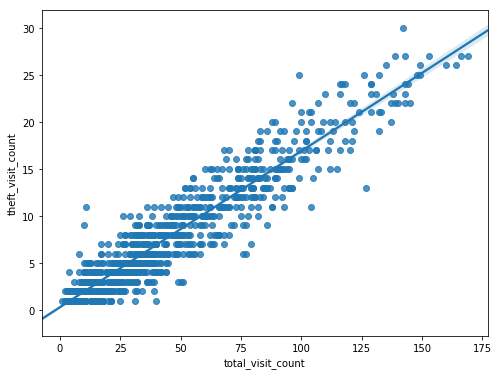

Correlation Matrix


,total_visit_count,theft_visit_count,theft_visit_ratio
total_visit_count,1.000,0.940,-0.205
theft_visit_count,0.940,1.000,0.014
theft_visit_ratio,-0.205,0.014,1.000


In [6]:
# Scatterplot with regression line
plt.rcParams['figure.figsize'] = (8, 6)
sns.regplot(x=visitor_df["total_visit_count"], y=visitor_df["theft_visit_count"])

# Correlation
plt.show()
print('Correlation Matrix')
visitor_df[['total_visit_count','theft_visit_count','theft_visit_ratio']].corr().round(3)


Correlation between theft_visit_count and total_visit_count is significantly high at 0.94 indicating that there is a strong positive relationship between these 2 variables. The scatterplot shows there are several outliers departing further from the regression line than most data points, these outliers can potentially be the thief visitors.

### Fit an Ordinary-Least-Square regression line using theft_visit_count and total_visit_count

In [7]:
# Fit a OLS model 
X = visitor_df['total_visit_count'].values.reshape(-1,1)
y = visitor_df['theft_visit_count'].values.reshape(-1,1)

ols = sm.OLS(y, sm.add_constant(X)).fit()
print ("The R-squared value is " + str(ols.rsquared))


The R-squared value is 0.8833188326301218


### Use Cook's distance to detect outliers
Cook's distance for an observation (x) measures how far the regression line would move if the line is fitted without that observation. A Cook's distance larger than 3 times the mean of the Cook's distances of all observations indicate that the observation is potentially an outlier.

Reference: https://www.mathworks.com/help/stats/cooks-distance.html

In [8]:
# Obtain summary of influence measures for OLS result
ols_infl = out_infl.OLSInfluence(ols)
influence_df = ols_infl.summary_frame()
influence_df.head()

,dfb_const,dfb_x1,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.000727,-0.003991,0.000030,-0.200411,0.001494,-0.007752,-0.200305,-0.007748
1,0.066068,-0.110278,0.006811,-1.149419,0.010205,-0.116713,-1.149622,-0.116734
2,0.006772,-0.003766,0.000027,0.190263,0.001489,0.007348,0.190162,0.007344
3,0.034377,-0.024344,0.000607,0.751306,0.002146,0.034840,0.751126,0.034832
4,-0.000301,0.007350,0.000072,0.285659,0.001759,0.011992,0.285514,0.011986


In [9]:
# Add Cook's distance to visitor dataframe
visitor_df['cooks_distance'] = influence_df['cooks_d']
# Sort visitors by value of Cook's distance
visitor_df = visitor_df.sort_values(by=['cooks_distance'],ascending=False)
# Only select visitor with Cook's distance larger than 3 times the mean of all Cook's distances
visitor_df = visitor_df[visitor_df.cooks_distance > visitor_df['cooks_distance'].mean()*3]
visitor_df = visitor_df.reset_index(drop=True)
visitor_df

,name,dob,visitor_id,total_visit_count,theft_visit_count,theft_visit_ratio,cooks_distance
0,Jason Villegas,1996-06-08,393,127,13,0.102362,0.059819
1,Karen Keeney,1993-12-25,503,142,30,0.211268,0.043373
2,Michael Mcbride,1993-04-26,683,99,25,0.252525,0.029761
3,Kim Palmer,1997-03-27,537,104,11,0.105769,0.021331
4,Oneida Randall,1995-09-11,725,11,11,1.000000,0.021106
5,Judith Sanders,1993-08-26,494,139,27,0.194245,0.014360
6,Loretta Massey,1997-05-11,596,10,9,0.900000,0.013686
7,Linda Gomez,1996-03-08,584,96,22,0.229167,0.013347
8,Cheryl Robinson,1996-04-05,119,116,24,0.206897,0.013212
9,Johnie Johnson,1995-12-28,463,117,24,0.205128,0.012533


It shows that there are 69 visitors that might suspects based on the value of their Cook's distance. As  total_visit_count and theft_visit_count are used to fit the regression line, these obtained Cook's distances indicate that these visitors have unusual values for these counts compared to most visitors.

### Show 20 most suspicious visitors with the highest Cook's distances 

In [10]:
visitor_df.head(20)

,name,dob,visitor_id,total_visit_count,theft_visit_count,theft_visit_ratio,cooks_distance
0,Jason Villegas,1996-06-08,393,127,13,0.102362,0.059819
1,Karen Keeney,1993-12-25,503,142,30,0.211268,0.043373
2,Michael Mcbride,1993-04-26,683,99,25,0.252525,0.029761
3,Kim Palmer,1997-03-27,537,104,11,0.105769,0.021331
4,Oneida Randall,1995-09-11,725,11,11,1.000000,0.021106
5,Judith Sanders,1993-08-26,494,139,27,0.194245,0.014360
6,Loretta Massey,1997-05-11,596,10,9,0.900000,0.013686
7,Linda Gomez,1996-03-08,584,96,22,0.229167,0.013347
8,Cheryl Robinson,1996-04-05,119,116,24,0.206897,0.013212
9,Johnie Johnson,1995-12-28,463,117,24,0.205128,0.012533
